In [101]:
import torch
import os
import numpy as np

## Purpose of this notebook

This notebook basically is helping me calm my mind, by showing that if you want to get a box from bigger image in two equivalent ways. The interpolation is used heavily by the Adam's code and I did not really understand why the two are equivivalent. So I decided to sit down and see this myself in 2D.

#### Side Effects
* It taught me how to use F.grid_sample functionality of Pytorch. This notebook is basically Peter Florence's copy from here https://gist.github.com/peteflorence/a1da2c759ca1ac2b74af9a83f69ce20e, except he does much more but only for one location.
* I demonstrate it over the grid.

In [102]:
%ls

README.md                hyperparams.py            runs/
Untitled.ipynb           hyperparams.pyc           sing.sh*
__pycache__/             logs_carla_sta/           tb.sh*
after_fix0.jpg           logs_mujoco_offline/      temp.binvox
after_fix1.jpg           logs_touch_embed/         temp_depth.jpg
after_fix2.jpg           main.py                   temp_save/
archs/                   make_train_file.py        temp_touch_model.py
backend/                 model_base.py             tunnel.sh*
binvox_rw.py             model_carla_flo.py        utils_basic.py
carla_flo_go.sh*         model_carla_sta.py        utils_basic.pyc
carla_sta_go.sh*         model_mujoco_offline.py   utils_box.pyc
checkpoints/             model_touch_embed.py      utils_eval.py
cuda_ops/                mujoco_points/            utils_geom.py
custom_go.sh*            my_mujoco_points/         utils_geom.pyc
depth_after_shuffle.jpg  nets/                     utils_improc.py
exp_base.py              new_depth.png  

In [103]:
image = "/home/gauravp/baby-groot.jpg"

In [104]:
import PIL.Image as Image
import matplotlib.pyplot as plt

In [105]:
img = Image.open(image)

In [106]:
img = img.resize(size=(256, 256))

In [107]:
img = np.asarray(img)
print(img.shape)

(256, 256, 3)


In [108]:
# slice up the image from the center of the image which is 128, 128
cx, cy = 128, 128
# see the assumption is x right and y goes down
xmin, xmax = (cx-32, cx+32)
ymin, ymax = (cy-32, cy+32)
sliced_img = img[ymin:ymax, xmin:xmax,:]

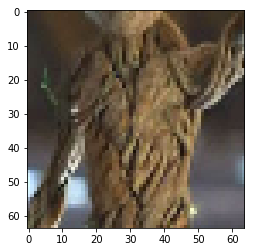

In [109]:
plt.imshow(sliced_img)

## Using grid sample to achieve the same thing

### Steps:
1. form the grid of size (1, 32, 32, 2) containing the pixel values you want to sample at:
    * This is a mesh grid from (xmin, xmax, ymin, ymax)
    * Normalize this grid

In [110]:
def make_grid(xmin,xmax,ymin,ymax,locs=64):
    xv = np.linspace(xmin, xmax, 64)
    yv = np.linspace(ymin, ymax, 64)
    grid = np.meshgrid(yv, xv)
    grid = np.stack((grid), axis=2)
    return grid

In [111]:
grid = make_grid(xmin, xmax, ymin, ymax, locs=64)

In [112]:
def normalize_grid(grid, H=256, W=256):
    grid[:, :, 0] = grid[:, :, 0] / (float(H)-1)
    grid[:, :, 1] = grid[:, :, 1] / (float(W)-1)
    grid = 2*grid - 1
    return grid

In [113]:
normalized_grid = normalize_grid(grid)

In [114]:
# finally sample at these locations from the bigger image using torch
torch_img = torch.from_numpy(img)
torch_img = torch_img.permute(2, 0, 1)
torch_img = torch.unsqueeze(torch_img, 0)
print(torch_img.shape)

torch.Size([1, 3, 256, 256])


In [115]:
torch_img = torch_img.float()

In [116]:
normalized_grid = torch.from_numpy(normalized_grid).float()

In [117]:
normalized_grid = torch.unsqueeze(normalized_grid, 0)

In [118]:
print(normalized_grid.shape)

torch.Size([1, 64, 64, 2])


In [119]:
# finally sample at these locations
sampled_img = torch.nn.functional.grid_sample(torch_img, normalized_grid)

In [120]:
sampled_img = sampled_img.squeeze(0).permute(1, 2, 0).cpu().numpy()

In [121]:
sampled_img = sampled_img.astype(np.uint8)

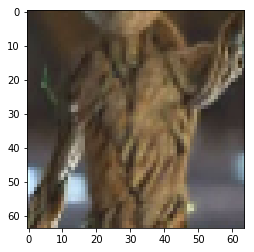

In [122]:
plt.imshow(sampled_img)

## Conclusion:
1. I get my peace of mind, that slicing is equivalent to bilinear sampling.
2. Slicing gives more jaggedy output whereas the bilinear sampling gives me more smooth output as seen in sliced_img plot vs sample_img plot
3. I can go ahead and do this same thing in 3d